In [53]:
import os
import h5py
import numpy as np

# Load all files from a directory
def load_all_data(folder_path):
    all_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".h5"):
            file_path = os.path.join(folder_path, file_name)
            with h5py.File(file_path, 'r') as f:
                timestamps = f['photon_data/timestamps'][:]
                detectors = f['photon_data/detectors'][:]
                all_data.append({"timestamps": timestamps, "detectors": detectors, "file": file_name})
    return all_data


folder_path = r"C:/Users/di76doj/Desktop/references MOYA/smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_20241106-225652"
data_files = load_all_data(folder_path)
print(f"Loaded {len(data_files)} files.")



Loaded 10 files.


In [55]:
from bokeh.io import show
from bokeh.models import ColumnDataSource, Range1d
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import HoverTool
import numpy as np

def plot_interactive_time_trace_bokehjs(timestamps, detectors, bin_width=1000):
    """
    Plot an interactive time trace for both detectors with opposite bars using BokehJS.
    
    Parameters:
    - timestamps: Array of photon timestamps.
    - detectors: Array of detector IDs (0 or 1).
    - bin_width: Binning width in microseconds.
    """
    # Bin timestamps
    max_time = timestamps.max()
    bins = np.arange(0, max_time + bin_width, bin_width)
    
    # Get counts for each detector
    det0_counts, _ = np.histogram(timestamps[detectors == 0], bins=bins)
    det1_counts, _ = np.histogram(timestamps[detectors == 1], bins=bins)
    
    # Time axis for plotting
    time_axis = bins[:-1]  # Exclude the last bin edge for alignment
    
    # Create ColumnDataSource for the detectors' data
    source_det0 = ColumnDataSource(data=dict(x=time_axis, y=det0_counts))
    source_det1 = ColumnDataSource(data=dict(x=time_axis, y=-det1_counts))  # Negative for downward bars
    
    # Create a Bokeh figure
    p = figure(title="Interactive Time Trace with Opposite Bars", 
               x_axis_label='Time (Microseconds)', y_axis_label='Photon Counts', 
               tools="pan,box_zoom,reset,save", width=800, height=400)
    
    # Plot bars for Detector 0 (upward bars)
    p.vbar(x='x', top='y', width=bin_width, source=source_det0, color="blue", legend_label="Detector 0 (Upward)")
    
    # Plot bars for Detector 1 (downward bars)
    p.vbar(x='x', top='y', width=bin_width, source=source_det1, color="green", legend_label="Detector 1 (Downward)")
    
    # Set y-axis limits (negative for downward bars)
    p.y_range = Range1d(start=-np.max(det1_counts), end=np.max(det0_counts))
    
    # Add a baseline at y=0
    p.line([0, max_time], [0, 0], line_width=2, line_dash="dashed", color="black")
    
    # Hover tool to show exact values
    hover = HoverTool()
    hover.tooltips = [("Time", "@x{0.0}"), ("Count", "@y")]
    p.add_tools(hover)
    
    # Show legend
    p.legend.location = "top_left"
    
    # Show the plot
    show(p)


# Assuming `data_files[0]` is loaded with "timestamps" and "detectors"
timestamps = data_files[0]["timestamps"]
detectors = data_files[0]["detectors"]
plot_interactive_time_trace_bokehjs(timestamps, detectors)


In [57]:
import pandas as pd
from tqdm import tqdm
import time

# Burst search function: Identify consecutive bursts
def find_bursts_consecutive(timestamps, max_gap_us, min_size, detector):
    bursts = []
    if len(timestamps) == 0:
        return bursts

    burst_start = timestamps[0]  # Start of the current burst
    burst_photon_count = 1       # Photon count in the current burst

    for i in range(1, len(timestamps)):
        if timestamps[i] - timestamps[i - 1] <= max_gap_us:
            # If within the max gap, extend the current burst
            burst_photon_count += 1
        else:
            # If gap exceeded, finish the current burst
            if burst_photon_count >= min_size:
                bursts.append({
                    "start_time": burst_start,
                    "end_time": timestamps[i - 1],
                    "length": timestamps[i - 1] - burst_start,
                    "size": burst_photon_count,
                    "detector": detector
                })
            # Start a new burst
            burst_start = timestamps[i]
            burst_photon_count = 1

    # Add the final burst if it meets the size threshold
    if burst_photon_count >= min_size:
        bursts.append({
            "start_time": burst_start,
            "end_time": timestamps[-1],
            "length": timestamps[-1] - burst_start,
            "size": burst_photon_count,
            "detector": detector
        })

    return bursts

# Process all files and detectors with progress bar and tally bursts
def process_all_files(data_files, max_gap_us, min_sizes):
    all_bursts = []  # To store all bursts for DataFrame creation
    burst_counts = {0: 0, 1: 0}  # Track burst counts for each detector
    total_tasks = len(data_files) * 2  # 2 detectors per file
    
    with tqdm(total=total_tasks, desc="Processing Files", unit="detector") as pbar:
        for data in data_files:
            timestamps = data["timestamps"]
            detectors = data["detectors"]
            for det in [0, 1]:  # Process each detector individually
                start_time = time.time()
                det_timestamps = timestamps[detectors == det]
                bursts = find_bursts_consecutive(det_timestamps, max_gap_us, min_sizes[det], det)
                burst_counts[det] += len(bursts)  # Increment the count for the detector
                
                # Add metadata and append to all_bursts
                for burst in bursts:
                    burst["file"] = data["file"]
                    all_bursts.append(burst)
                
                pbar.update(1)  # Update the progress bar
                elapsed_time = time.time() - start_time
                print(f"Detector {det} in file {data['file']} processed in {elapsed_time:.2f} seconds.")
    
    # Print total bursts found for each detector
    print("\nSummary of Detected Bursts:")
    for det in [0, 1]:
        print(f"Detector {det}: Total bursts detected = {burst_counts[det]}")
    
    # Create DataFrame
    df_bursts = pd.DataFrame(all_bursts)
    
    # Display the first and last 100 rows
    print("\nFirst 100 Rows of the DataFrame:")
    print(df_bursts.head(100))
    
    print("\nLast 100 Rows of the DataFrame:")
    print(df_bursts.tail(100))
    
    return df_bursts

# Example usage
min_sizes = {0: 20, 1: 20}  # Minimum burst size thresholds for each detector
max_gap_us = 500           # Maximum allowed gap between consecutive timestamps in microseconds
burst_df = process_all_files(data_files, max_gap_us, min_sizes)


Processing Files:  10%|█         | 2/20 [00:00<00:02,  8.33detector/s]

Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_0.h5 processed in 0.11 seconds.
Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_0.h5 processed in 0.13 seconds.


Processing Files:  25%|██▌       | 5/20 [00:00<00:01,  9.71detector/s]

Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_1.h5 processed in 0.09 seconds.
Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_1.h5 processed in 0.08 seconds.
Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_2.h5 processed in 0.11 seconds.


Processing Files:  35%|███▌      | 7/20 [00:00<00:01, 11.05detector/s]

Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_2.h5 processed in 0.07 seconds.
Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_3.h5 processed in 0.08 seconds.
Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_3.h5 processed in 0.11 seconds.


Processing Files:  45%|████▌     | 9/20 [00:00<00:01, 10.35detector/s]

Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_4.h5 processed in 0.10 seconds.
Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_4.h5 processed in 0.11 seconds.


Processing Files:  65%|██████▌   | 13/20 [00:01<00:00, 10.07detector/s]

Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_5.h5 processed in 0.11 seconds.
Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_5.h5 processed in 0.08 seconds.
Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_6.h5 processed in 0.11 seconds.


Processing Files:  75%|███████▌  | 15/20 [00:01<00:00, 10.10detector/s]

Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_6.h5 processed in 0.09 seconds.
Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_7.h5 processed in 0.11 seconds.
Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_7.h5 processed in 0.07 seconds.


Processing Files:  95%|█████████▌| 19/20 [00:01<00:00, 10.55detector/s]

Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_8.h5 processed in 0.10 seconds.
Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_8.h5 processed in 0.09 seconds.
Detector 0 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_9.h5 processed in 0.10 seconds.


Processing Files: 100%|██████████| 20/20 [00:01<00:00, 10.34detector/s]


Detector 1 in file smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_9.h5 processed in 0.08 seconds.

Summary of Detected Bursts:
Detector 0: Total bursts detected = 1332
Detector 1: Total bursts detected = 1007

First 100 Rows of the DataFrame:
    start_time  end_time  length  size  detector  \
0        18255     19327    1072    29         0   
1        38957     46231    7274   227         0   
2        60036     60642     606    47         0   
3        85941     87564    1623    20         0   
4        89087     89985     898    25         0   
..         ...       ...     ...   ...       ...   
95     4598753   4601676    2923    26         0   
96     4710539   4711778    1239    49         0   
97     4752811   4755291    2480    40         0   
98     4785833   4787264    1431    76         0   
99     4863255   4864103     848   182         0   

                                                 file  
0   smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgree...  
1   smFRET_

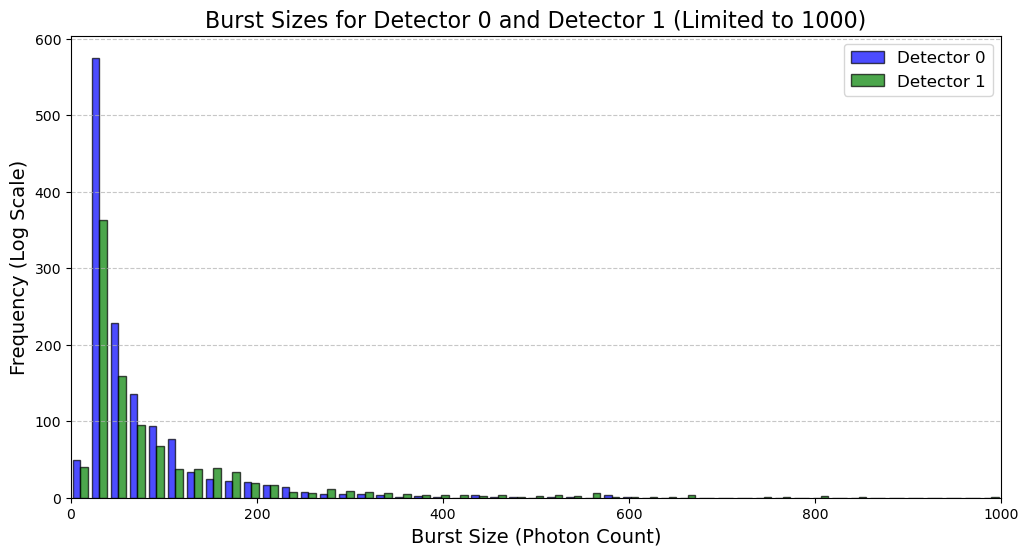

C:\Users\di76doj\AppData\Local\Temp\ipykernel_19124\1177230672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  det0_bursts["length"] = det0_bursts["end_time"] - det0_bursts["start_time"]
C:\Users\di76doj\AppData\Local\Temp\ipykernel_19124\1177230672.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  det1_bursts["length"] = det1_bursts["end_time"] - det1_bursts["start_time"]


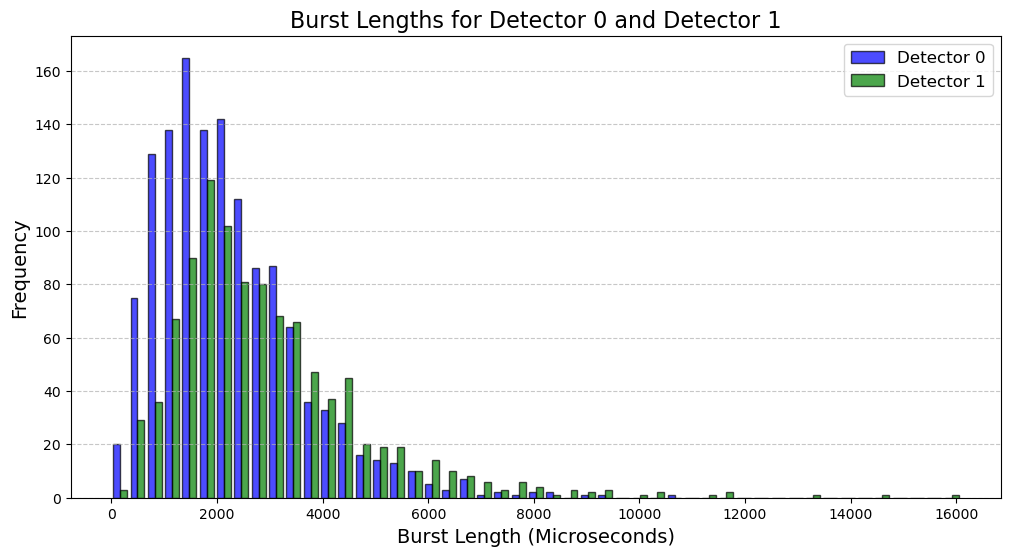

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def plot_burst_histograms_log_y_with_limit(burst_df):
    # Separate bursts by detector
    det0_bursts = burst_df[burst_df["detector"] == 0]
    det1_bursts = burst_df[burst_df["detector"] == 1]
    
    # Prepare the burst size data
    det0_sizes = det0_bursts["size"]
    det1_sizes = det1_bursts["size"]
    
    # Prepare bins (shared between detectors for alignment)
    bins = np.linspace(0, 1000, 50)  # Linear bins up to a max size of 1000
    
    # Plot burst size histograms side-by-side
    plt.figure(figsize=(12, 6))
    plt.hist(
        [det0_sizes, det1_sizes],
        bins=bins,
        label=["Detector 0", "Detector 1"],
        color=["blue", "green"],
        alpha=0.7,
        edgecolor="black"
    )
    #plt.yscale("log")  # Logarithmic y-axis
    plt.xlim(0, 1000)  # Limit x-axis to a max burst size of 1000
    plt.title("Burst Sizes for Detector 0 and Detector 1 (Limited to 1000)", fontsize=16)
    plt.xlabel("Burst Size (Photon Count)", fontsize=14)
    plt.ylabel("Frequency (Log Scale)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Burst Lengths
    det0_bursts["length"] = det0_bursts["end_time"] - det0_bursts["start_time"]
    det1_bursts["length"] = det1_bursts["end_time"] - det1_bursts["start_time"]
    
    det0_lengths = det0_bursts["length"]
    det1_lengths = det1_bursts["length"]
    
    # Prepare bins for lengths
    max_length = max(det0_lengths.max(), det1_lengths.max())
    bins = np.linspace(0, max_length, 50)  # Linear bins for lengths
    
    # Plot burst length histograms side-by-side
    plt.figure(figsize=(12, 6))
    plt.hist(
        [det0_lengths, det1_lengths],
        bins=bins,
        label=["Detector 0", "Detector 1"],
        color=["blue", "green"],
        alpha=0.7,
        edgecolor="black"
    )
    plt.title("Burst Lengths for Detector 0 and Detector 1", fontsize=16)
    plt.xlabel("Burst Length (Microseconds)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_burst_histograms_log_y_with_limit(burst_df)


In [61]:
from tqdm import tqdm

def find_coincident_bursts_with_threshold_and_summary(df_bursts, coincidence_threshold_us):
    coincident_bursts = []
    
    # Separate bursts by detector
    det0_bursts = df_bursts[df_bursts["detector"] == 0]
    det1_bursts = df_bursts[df_bursts["detector"] == 1]
    
    # Total comparisons for the progress bar
    total_comparisons = len(det0_bursts) * len(det1_bursts)
    progress_desc = "Finding Coincidences with Threshold"
    
    # Iterate over all bursts from detector 0 with a progress bar
    with tqdm(total=total_comparisons, desc=progress_desc, unit="comparison") as pbar:
        for _, burst0 in det0_bursts.iterrows():
            for _, burst1 in det1_bursts.iterrows():
                # Check if bursts coincide within the threshold
                if (
                    abs(burst0["start_time"] - burst1["start_time"]) <= coincidence_threshold_us and
                    abs(burst0["end_time"] - burst1["end_time"]) <= coincidence_threshold_us
                ):
                    coincident_bursts.append({
                        "start_time": min(burst0["start_time"], burst1["start_time"]),
                        "end_time": max(burst0["end_time"], burst1["end_time"]),
                        "size_det0": burst0["size"],
                        "size_det1": burst1["size"],
                        "file_det0": burst0["file"],
                        "file_det1": burst1["file"],
                        "time_difference_start_us": abs(burst0["start_time"] - burst1["start_time"]),
                        "time_difference_end_us": abs(burst0["end_time"] - burst1["end_time"])
                    })
                pbar.update(1)  # Update the progress bar
    
    # Create a DataFrame from the coincident bursts
    df_coincident_bursts = pd.DataFrame(coincident_bursts)
    
    # Generate a summary
    if not df_coincident_bursts.empty:
        print("\nSummary of Coincident Bursts:")
        print(f"Total coincident bursts found: {len(df_coincident_bursts)}")
        
        # Time differences
        min_diff_start = df_coincident_bursts["time_difference_start_us"].min()
        max_diff_start = df_coincident_bursts["time_difference_start_us"].max()
        avg_diff_start = df_coincident_bursts["time_difference_start_us"].mean()
        
        min_diff_end = df_coincident_bursts["time_difference_end_us"].min()
        max_diff_end = df_coincident_bursts["time_difference_end_us"].max()
        avg_diff_end = df_coincident_bursts["time_difference_end_us"].mean()
        
        print(f"Start time differences (µs): Min = {min_diff_start}, Max = {max_diff_start}, Avg = {avg_diff_start:.2f}")
        print(f"End time differences (µs): Min = {min_diff_end}, Max = {max_diff_end}, Avg = {avg_diff_end:.2f}")
        
        # Breakdown by file
        file_summary = df_coincident_bursts.groupby("file_det0").size()
        print("\nBreakdown of coincident bursts by file:")
        print(file_summary)
    else:
        print("No coincident bursts found.")
    
    # Display the first and last 100 rows of the coincident bursts
    print("\nFirst 100 Coincident Bursts:")
    print(df_coincident_bursts.head(100))
    
    print("\nLast 100 Coincident Bursts:")
    print(df_coincident_bursts.tail(100))
    
    return df_coincident_bursts

# Example usage
coincidence_threshold_us = 500  # Define the time coincidence threshold in microseconds
df_coincident = find_coincident_bursts_with_threshold_and_summary(burst_df, coincidence_threshold_us)


Finding Coincidences with Threshold: 100%|██████████| 1341324/1341324 [02:01<00:00, 11068.53comparison/s]


Summary of Coincident Bursts:
Total coincident bursts found: 127
Start time differences (µs): Min = 0, Max = 499, Avg = 210.98
End time differences (µs): Min = 0, Max = 497, Avg = 213.54

Breakdown of coincident bursts by file:
file_det0
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_0.h5    27
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_1.h5    15
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_2.h5    10
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_3.h5     9
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_4.h5    12
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_5.h5    13
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_6.h5     9
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_7.h5    12
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_8.h5    11
smFRET_dsDNA-13bp_Cy3b-Atto647N_0.1nM_60uWgreen_25uWred_9.h5     9
dtype: int64

First 100 Coincident Bursts:
    start_time  end_time  size_det0  size_det1  

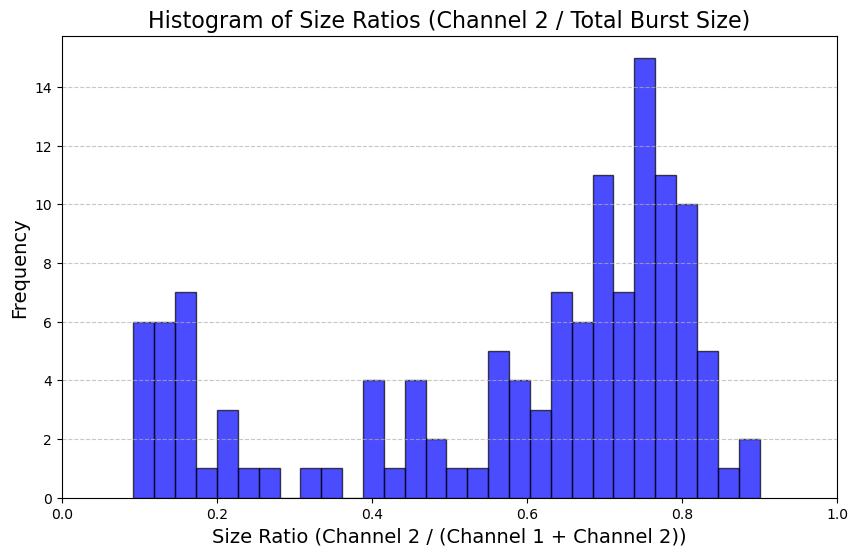

In [37]:
import matplotlib.pyplot as plt

def plot_size_ratio_histogram(df_coincident):
    # Calculate the size ratio for each coinciding burst
    df_coincident["size_ratio"] = df_coincident["size_det1"] / (
        df_coincident["size_det1"] + df_coincident["size_det0"]
    )
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(
        df_coincident["size_ratio"],
        bins=30,  # Number of bins
        color="blue",
        alpha=0.7,
        edgecolor="black"
    )
    plt.title("Histogram of Size Ratios (Channel 2 / Total Burst Size)", fontsize=16)
    plt.xlabel("Size Ratio (Channel 2 / (Channel 1 + Channel 2))", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xlim(0, 1)  # Set x-axis range from 0 to 1
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Example usage
plot_size_ratio_histogram(df_coincident)

